In [29]:
import matplotlib.pyplot as plt
import numpy as np
import flet as ft
import os
from pylsl import StreamInlet, resolve_stream
from scipy.signal import welch, spectrogram
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
import pandas as pd
from joblib import dump
import pyxdf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import seaborn as sns

In [30]:
# Combine all data stored in the same folder to use for training the model.
def concat_data(frequency):
    data_folder = f'../../../../data_ssvep/Toey/SSVEP_data/{frequency}/'
    all_data = []
    for file_name in os.listdir(data_folder):
        file_path = os.path.join(data_folder, file_name)
        streams, _ = pyxdf.load_xdf(file_path)
        raw_data = streams[0]["time_series"].T
        all_data.append(raw_data)
    all_data_array = np.concatenate(all_data, axis=1)
    return all_data_array


In [31]:
# The stored data will be kept for an average of 80 seconds, so the data will be cut into parts. set_size is the sample that you want per 1 set. overlap is how much data in each set will overlap.
def create_overlapping_sets(data, set_size=500, overlap_fraction=0.5):
    step = int(set_size * (1 - overlap_fraction))
    sets = []
    for i in range(0, len(data) - set_size + 1, step):
        sets.append(data[i:i + set_size])
    return sets

In [32]:
raw_data1 = concat_data('6Hz')
print(raw_data1.shape)
raw_data2 = concat_data('20Hz')
print(raw_data2.shape)
raw_data3 = concat_data('0Hz')
print(raw_data3.shape)

(8, 144520)
(8, 164360)
(8, 137610)


In [33]:
# Store data in only 4 channels: Oz Pz O1 O2
data1 = raw_data1[0:4,:]
data2 = raw_data2[0:4,:]
data3 = raw_data3[0:4,:]
print(data1.shape)
print(data2.shape)
print(data3.shape)

(4, 144520)
(4, 164360)
(4, 137610)


In [34]:
# Adjust the reference using Pz as the channel ref.
data1_oz = data1[0] - data1[1]
data1_o1 = data1[2] - data1[1]
data1_o2 = data1[3] - data1[1]

data2_oz = data2[0] - data2[1]
data2_o1 = data2[2] - data2[1]
data2_o2 = data2[3] - data2[1]

data3_oz = data3[0] - data3[1]
data3_o1 = data3[2] - data3[1]
data3_o2 = data3[3] - data3[1]

print(data1_oz.shape, data1_o1.shape, data1_o2.shape)
print(data2_oz.shape, data2_o1.shape, data2_o2.shape)
print(data3_oz.shape, data3_o1.shape, data3_o2.shape)

(144520,) (144520,) (144520,)
(164360,) (164360,) (164360,)
(137610,) (137610,) (137610,)


In [35]:
# The number seen is the number of members in the list, each member containing 1000 samples.
data1_set_oz = create_overlapping_sets(data1_oz, set_size=1000, overlap_fraction=0.5)
data1_set_o1 = create_overlapping_sets(data1_o1, set_size=1000, overlap_fraction=0.5)
data1_set_o2 = create_overlapping_sets(data1_o2, set_size=1000, overlap_fraction=0.5)

data2_set_oz = create_overlapping_sets(data2_oz, set_size=1000, overlap_fraction=0.5)
data2_set_o1 = create_overlapping_sets(data2_o1, set_size=1000, overlap_fraction=0.5)
data2_set_o2 = create_overlapping_sets(data2_o2, set_size=1000, overlap_fraction=0.5)

data3_set_oz = create_overlapping_sets(data3_oz, set_size=1000, overlap_fraction=0.5)
data3_set_o1 = create_overlapping_sets(data3_o1, set_size=1000, overlap_fraction=0.5)
data3_set_o2 = create_overlapping_sets(data3_o2, set_size=1000, overlap_fraction=0.5)

In [36]:
print(len(data1_set_oz), len(data1_set_o1), len(data1_set_o2))
print(len(data2_set_oz), len(data2_set_o1), len(data2_set_o2))
print(len(data3_set_oz), len(data3_set_o1), len(data3_set_o2))

288 288 288
327 327 327
274 274 274


In [37]:
import numpy as np
from scipy.signal import welch, find_peaks, butter, filtfilt
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import CCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

# Define function to calculate PSD
def calculate_psd(data, fs=250, nperseg=250*4):
    f, Pxx = welch(data, fs=fs, nperseg=nperseg)
    return f, Pxx

# Define function to detect peaks
def detect_peaks(Pxx):
    peaks, _ = find_peaks(Pxx)
    return peaks

# Define function for band-pass filtering
def band_pass_filter(data, lowcut, highcut, fs=250, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

# Apply band-pass filter and calculate PSD for each dataset
def process_data(data_set):
    filtered_data = [band_pass_filter(epoch, 0.5, 50) for epoch in data_set]
    data_fft = []
    for epoch in filtered_data:
        f, Pxx = calculate_psd(epoch)
        peaks = detect_peaks(Pxx)
        data_fft.append(Pxx[:121])
    return data_fft

In [38]:
# Process each dataset
data1_fft_oz = process_data(data1_set_oz)
data1_fft_o1 = process_data(data1_set_o1)
data1_fft_o2 = process_data(data1_set_o2)

data2_fft_oz = process_data(data2_set_oz)
data2_fft_o1 = process_data(data2_set_o1)
data2_fft_o2 = process_data(data2_set_o2)

data3_fft_oz = process_data(data3_set_oz)
data3_fft_o1 = process_data(data3_set_o1)
data3_fft_o2 = process_data(data3_set_o2)

# Combine the data
combined_data1 = np.hstack((data1_fft_oz, data1_fft_o1, data1_fft_o2))
combined_data2 = np.hstack((data2_fft_oz, data2_fft_o1, data2_fft_o2))
combined_data3 = np.hstack((data3_fft_oz, data3_fft_o1, data3_fft_o2))

# Combine all data
combined_data = np.vstack((combined_data1, combined_data2, combined_data3))

# Create labels for each class
labels = np.array([0]*len(data1_fft_oz) + [1]*len(data2_fft_oz) + [2]*len(data3_fft_oz))

# Check that the combined data and labels have the correct shape
print(f"Combined data shape: {combined_data.shape}")
print(f"Labels shape: {labels.shape}")

Combined data shape: (889, 363)
Labels shape: (889,)


In [46]:
# Canonical Correlation Analysis (CCA)
cca = CCA(n_components=1)  
combined_data_cca = cca.fit_transform(combined_data, labels)

# For each array in the tuple, access and perform a flat transformation.
combined_data_flat = np.hstack([arr.reshape(-1, 1) for arr in combined_data_cca])

# Features Normalization
scaler = StandardScaler()
X_normalized = scaler.fit_transform(combined_data_flat)

# Features Classification using Random Forest
X_train, X_test, y_train, y_test = train_test_split(X_normalized, labels, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(711, 2)
(178, 2)
(711,)
(178,)


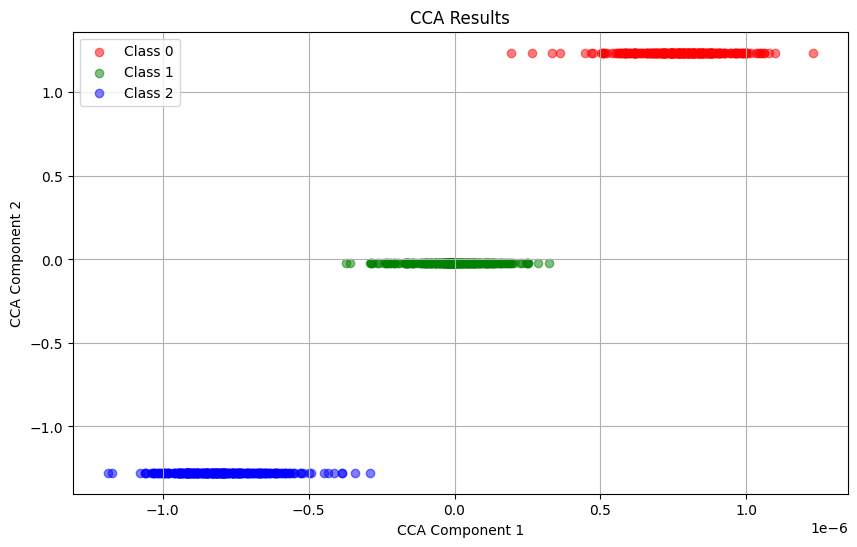

In [58]:
plt.figure(figsize=(10, 6))

# Assuming labels are provided as an array with the same length as the data
classes = np.unique(labels)
colors = ['r', 'g', 'b']  # Assigning a color for each class

for i, cls in enumerate(classes):
    plt.scatter(combined_data_flat[labels == cls, 0], combined_data_flat[labels == cls, 1], 
                color=colors[i], label=f'Class {cls}', alpha=0.5)

plt.xlabel('CCA Component 1')
plt.ylabel('CCA Component 2')
plt.title('CCA Results')
plt.legend()
plt.grid(True)
plt.show()

Epoch 1/50


C:\Users\Toey\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5572 - loss: 0.9426   
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - accuracy: 0.9127 - loss: 0.4618
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9789 - loss: 0.2852 
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.1459 
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - accuracy: 1.0000 - loss: 0.0518
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0209 
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step - accuracy: 1.0000 - loss: 0.0105
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0073 
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0043 
Epoch 10/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - accuracy: 1.0000 - loss: 0.0039
Epoch 11/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - accuracy: 1.0000 - loss: 0.0028
Epoch 12/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.00

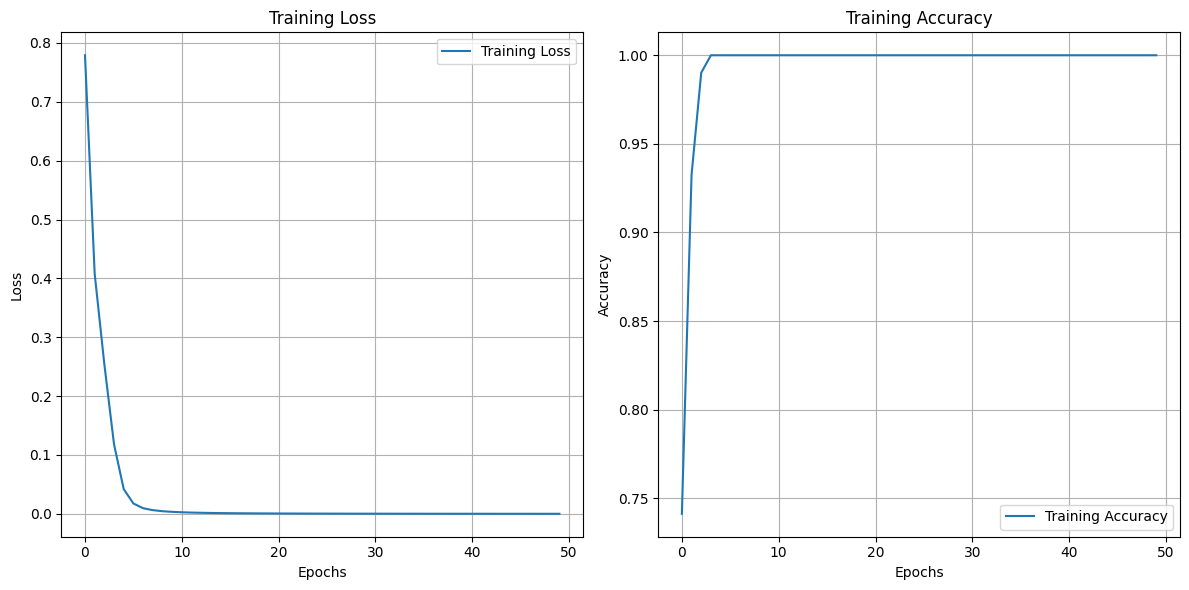

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


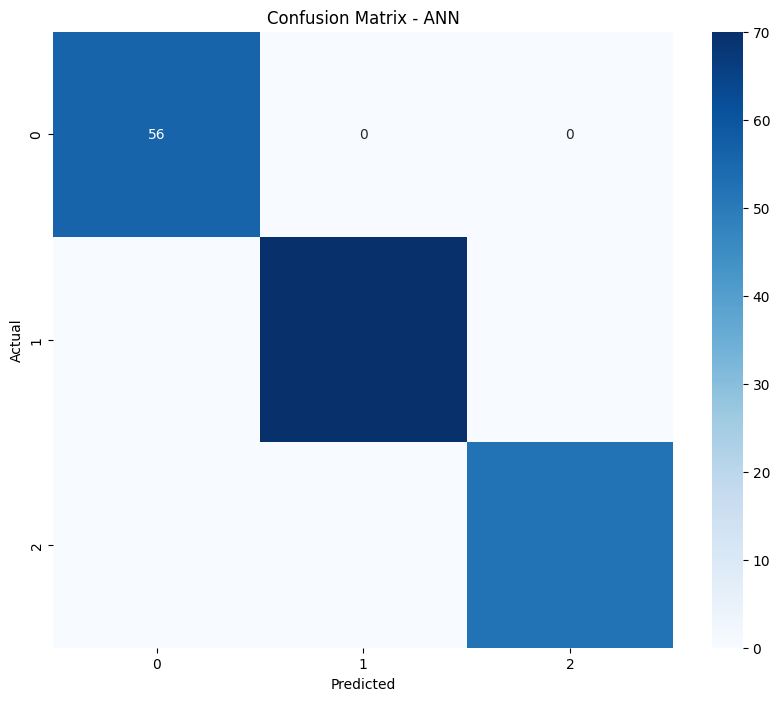

In [59]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

# แปลง y_train และ y_test ให้เป็นแบบ one-hot encoding
num_classes = len(np.unique(y_train))
y_train_one_hot = to_categorical(y_train, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)

# สร้างโมเดล ANN แบบ Feed-Forward
ann_model = Sequential()
ann_model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
ann_model.add(Dense(64, activation='relu'))
ann_model.add(Dense(num_classes, activation='softmax'))

# คอมไพล์โมเดล
ann_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# ฝึกโมเดล
ann_model.fit(X_train, y_train_one_hot, epochs=50, batch_size=32, verbose=1)

# Plot loss and accuracy
plt.figure(figsize=(12, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(ann_model.history.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(ann_model.history.history['accuracy'], label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# ทำนายบน test set
y_pred_ann = np.argmax(ann_model.predict(X_test), axis=1)

ann_model.save("model_P_CCA/ann_model.h5")

# ประเมิน precision, recall, และ F1-score ของแต่ละคลาส
precision_ann_per_class = precision_score(y_test, y_pred_ann, average=None)
recall_ann_per_class = recall_score(y_test, y_pred_ann, average=None)
f1_ann_per_class = f1_score(y_test, y_pred_ann, average=None)

# คำนวณ accuracy ของแต่ละคลาส
accuracy_ann_per_class = []
for class_label in range(len(precision_ann_per_class)):
    correct_predictions = ((y_pred_ann == class_label) & (y_test == class_label)).sum()
    total_predictions = (y_pred_ann == class_label).sum()
    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    accuracy_ann_per_class.append(accuracy)

# คำนวณค่าเฉลี่ยของ accuracy
avg_accuracy_ann = accuracy_score(y_test, y_pred_ann)

# เฉลี่ย precision, recall, และ F1-score ของแต่ละคลาส
avg_precision_ann = precision_score(y_test, y_pred_ann, average='weighted')
avg_recall_ann = recall_score(y_test, y_pred_ann, average='weighted')
avg_f1_ann = f1_score(y_test, y_pred_ann, average='weighted')

# สร้าง DataFrame จากผลลัพธ์
results_ann_df = pd.DataFrame({
    'Class': range(len(precision_ann_per_class)),
    'Precision': precision_ann_per_class,
    'Recall': recall_ann_per_class,
    'F1-score': f1_ann_per_class,
    'Accuracy': accuracy_ann_per_class
})

# เพิ่มค่าเฉลี่ยของ accuracy และ precision, recall, F1-score ลงในตาราง
results_ann_df.loc['average'] = [None, avg_precision_ann, avg_recall_ann, avg_f1_ann, avg_accuracy_ann]

conf_matrix_knn = confusion_matrix(y_test, y_pred_ann)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_knn, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - ANN')
plt.show()

(711, 2)
(178, 2)
Epoch 1/100


C:\Users\Toey\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8516 - loss: 0.4279
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9999 - loss: 0.0026
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0022   
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 9.5479e-04
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9999 - loss: 7.0536e-04
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0035   
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 0.0035
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 1.4630e-04
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 7.7757e-05
Epoch 10/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 6.7453e-05 
Epoch 11/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 7.7349e-05 
Epoch 12/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 

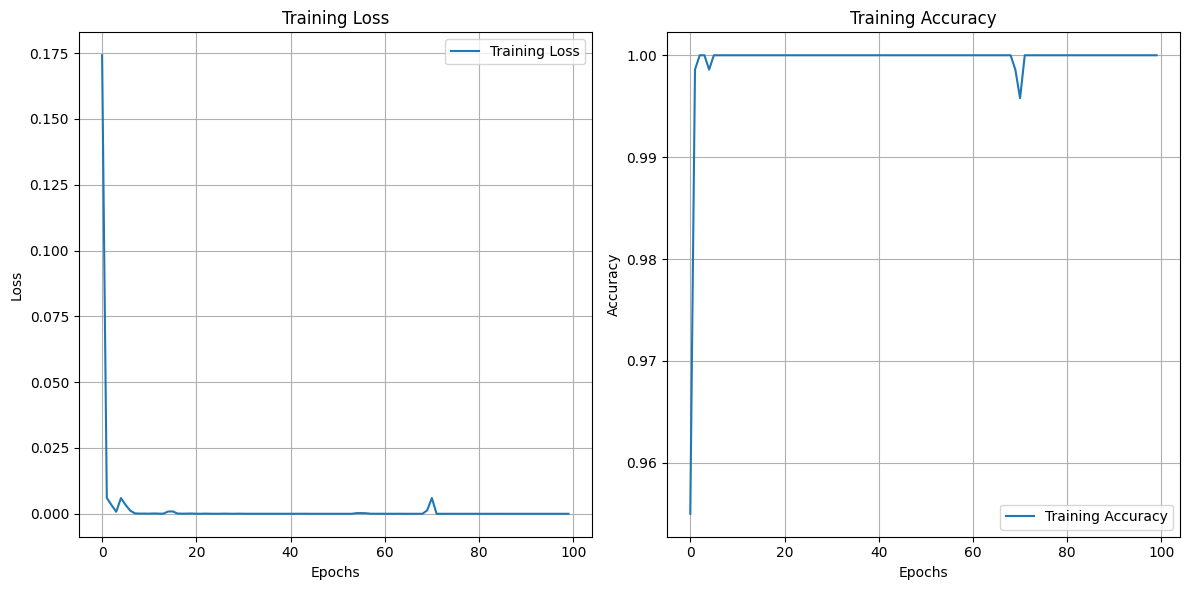

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


         Class  Precision  Recall  F1-score  Accuracy
0          0.0        1.0     1.0       1.0       1.0
1          1.0        1.0     1.0       1.0       1.0
2          2.0        1.0     1.0       1.0       1.0
average    NaN        1.0     1.0       1.0       1.0


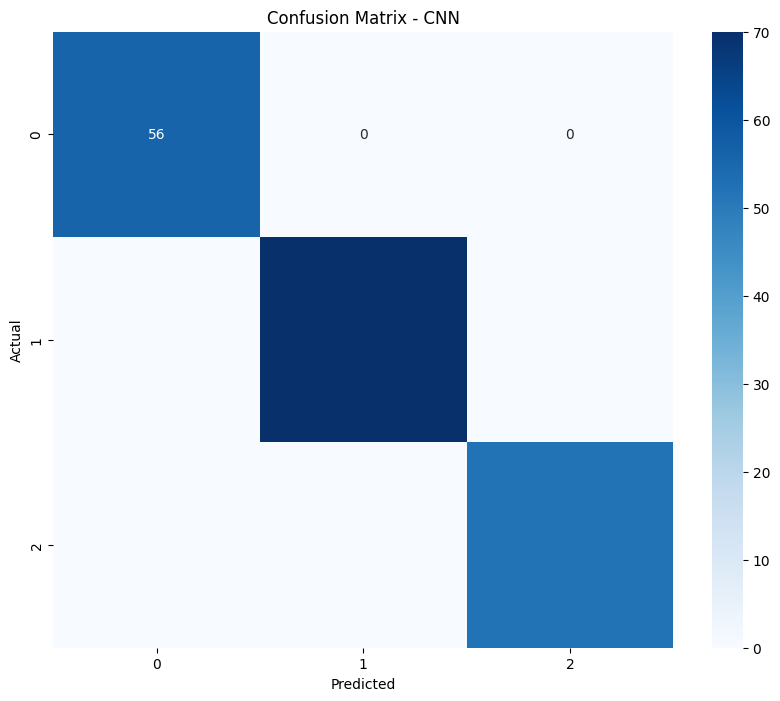

In [60]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Dense, ReLU, Softmax, Flatten
from tensorflow.keras.utils import to_categorical

# Normalize ข้อมูล
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape)
print(X_test.shape)

# ปรับข้อมูลให้เป็นรูปแบบ 3D สำหรับ Conv1D
X_train_reshaped = X_train.reshape(-1, 2, 1)
X_test_reshaped = X_test.reshape(-1, 2, 1)

# สร้างโมเดล CNN สำหรับข้อมูล 1D
model = Sequential()

# Convolution Layer
model.add(Conv1D(filters=64, kernel_size=3, input_shape=(2, 1), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=1))  # แก้เป็น pool_size=1
model.add(ReLU())

# เพิ่มอีก Convolution Layer
model.add(Conv1D(filters=64, kernel_size=3, padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=1))  # แก้เป็น pool_size=1
model.add(ReLU())

# Dense Layer
model.add(Flatten())
model.add(Dense(units=256))
model.add(ReLU())

# Output Layer
num_classes = len(np.unique(y_train))
model.add(Dense(units=num_classes))
model.add(Softmax())

# คอมไพล์โมเดล
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# แปลง y_train และ y_test ให้เป็นแบบ one-hot encoding
y_train_one_hot = to_categorical(y_train, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)

# ฝึกโมเดล
model.fit(X_train_reshaped, y_train_one_hot, epochs=100, batch_size=32, verbose=1)
# Plot loss and accuracy
plt.figure(figsize=(12, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(model.history.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(model.history.history['accuracy'], label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# ทำนายบน test set
y_pred_cnn = np.argmax(model.predict(X_test_reshaped), axis=1)

dump(scaler, 'model_P_CCA/cnn_scaler.pkl')
model.save("model_P_CCA/cnn_model.h5")

# ประเมิน precision, recall, และ F1-score ของแต่ละคลาส
precision_cnn_per_class = precision_score(y_test, y_pred_cnn, average=None)
recall_cnn_per_class = recall_score(y_test, y_pred_cnn, average=None)
f1_cnn_per_class = f1_score(y_test, y_pred_cnn, average=None)

# คำนวณ accuracy ของแต่ละคลาส
accuracy_cnn_per_class = []
for class_label in range(len(precision_cnn_per_class)):
    correct_predictions = ((y_pred_cnn == class_label) & (y_test == class_label)).sum()
    total_predictions = (y_pred_cnn == class_label).sum()
    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    accuracy_cnn_per_class.append(accuracy)

# คำนวณค่าเฉลี่ยของ accuracy
avg_accuracy_cnn = accuracy_score(y_test, y_pred_cnn)

# เฉลี่ย precision, recall, และ F1-score ของแต่ละคลาส
avg_precision_cnn = precision_score(y_test, y_pred_cnn, average='weighted')
avg_recall_cnn = recall_score(y_test, y_pred_cnn, average='weighted')
avg_f1_cnn = f1_score(y_test, y_pred_cnn, average='weighted')

# สร้าง DataFrame จากผลลัพธ์
results_cnn_df = pd.DataFrame({
    'Class': range(len(precision_cnn_per_class)),
    'Precision': precision_cnn_per_class,
    'Recall': recall_cnn_per_class,
    'F1-score': f1_cnn_per_class,
    'Accuracy': accuracy_cnn_per_class
})


# เพิ่มค่าเฉลี่ยของ accuracy และ precision, recall, F1-score ลงในตาราง
results_cnn_df.loc['average'] = [None, avg_precision_cnn, avg_recall_cnn, avg_f1_cnn, avg_accuracy_cnn]
print(results_cnn_df)
conf_matrix_knn = confusion_matrix(y_test, y_pred_cnn)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_knn, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - CNN')
plt.show()


Epoch 1/100


C:\Users\Toey\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.5718 - loss: 1.0834 - val_accuracy: 0.8708 - val_loss: 0.8538 - learning_rate: 0.0010
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8804 - loss: 0.7246 - val_accuracy: 0.7528 - val_loss: 0.4775 - learning_rate: 0.0010
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8121 - loss: 0.4016 - val_accuracy: 0.9157 - val_loss: 0.3680 - learning_rate: 0.0010
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9535 - loss: 0.3103 - val_accuracy: 1.0000 - val_loss: 0.1991 - learning_rate: 0.0010
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9964 - loss: 0.1465 - val_accuracy: 1.0000 - val_loss: 0.0438 - learning_rate: 0.0010
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0371 - val_accuracy: 1.0000 - val_loss: 0.0254 - learning_rate: 0.0010
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0254 - val_accuracy: 1.00

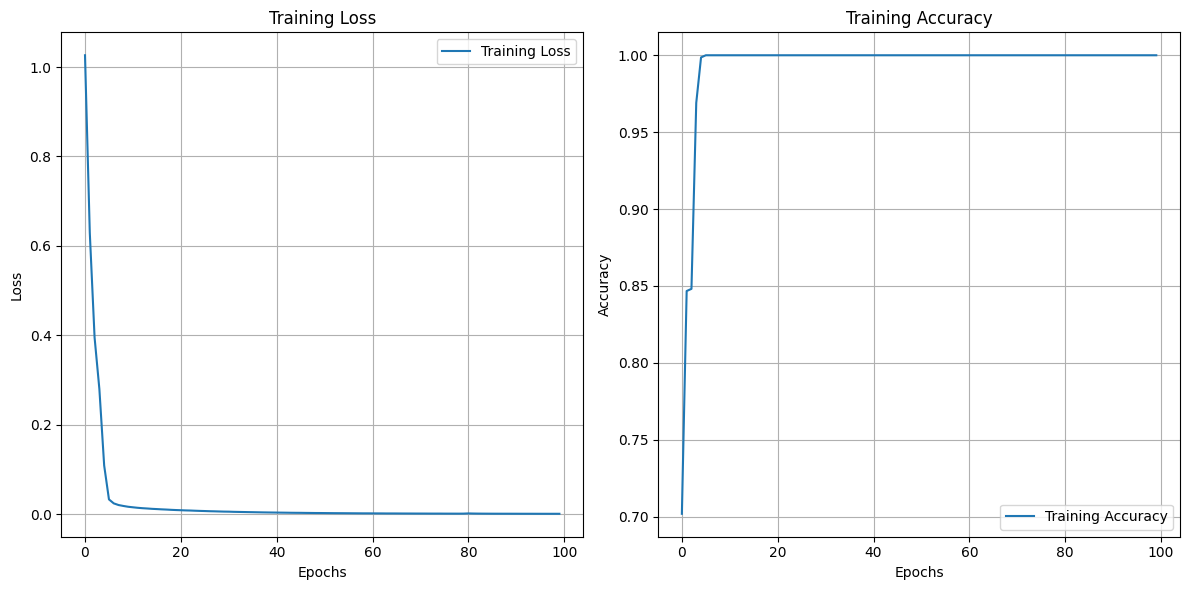

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step
         Class  Precision  Recall  F1-score  Accuracy
0          0.0        1.0     1.0       1.0       1.0
1          1.0        1.0     1.0       1.0       1.0
2          2.0        1.0     1.0       1.0       1.0
average    NaN        1.0     1.0       1.0       1.0


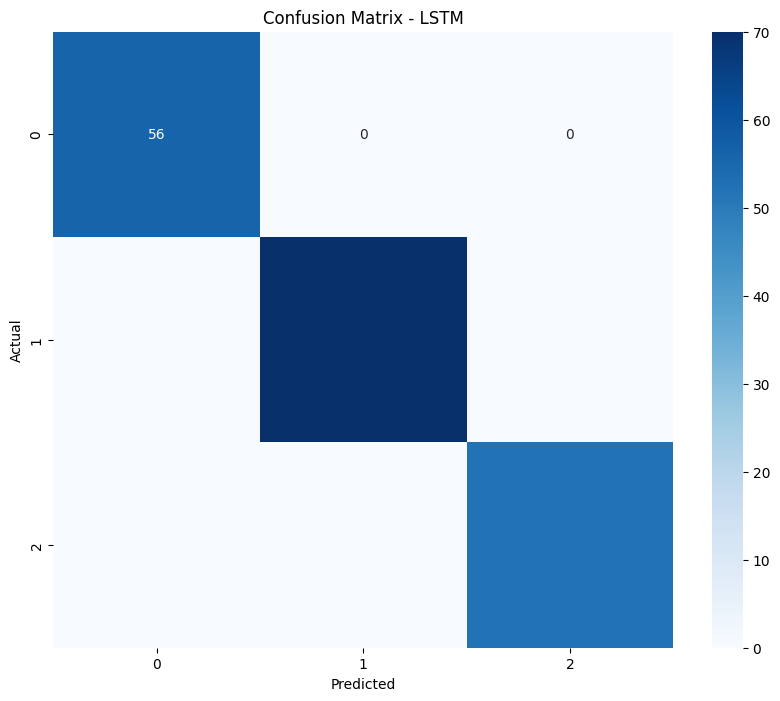

In [61]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Normalize ข้อมูล
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ปรับข้อมูลให้เป็นรูปแบบ 3D สำหรับ LSTM
X_train_reshaped = X_train.reshape(-1, 2, 1)
X_test_reshaped = X_test.reshape(-1, 2, 1)

# สร้างโมเดล LSTM
model = Sequential()

# LSTM Layer 1
model.add(Bidirectional(LSTM(50, return_sequences=True, input_shape=(2, 1), kernel_regularizer=l2(0.0001))))
model.add(Dropout(0.3))

# LSTM Layer 2
model.add(Bidirectional(LSTM(70, return_sequences=False, kernel_regularizer=l2(0.0001))))
model.add(Dropout(0.3))

# Fully Connected Layer
model.add(Dense(5, activation='relu'))

# Output Layer with Softmax
model.add(Dense(len(np.unique(y_train)), activation='softmax'))

# คอมไพล์โมเดล
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# แปลง y_train และ y_test ให้เป็นแบบ one-hot encoding
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=len(np.unique(y_train)))
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes=len(np.unique(y_train)))

# Reduce learning rate when a metric has stopped improving.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.00001, verbose=1)

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)

# ฝึกโมเดล
model.fit(X_train_reshaped, y_train_one_hot, epochs=100, batch_size=32, validation_data=(X_test_reshaped, y_test_one_hot), callbacks=[reduce_lr, early_stopping], verbose=1)
# Plot loss and accuracy
plt.figure(figsize=(12, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(model.history.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(model.history.history['accuracy'], label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
dump(scaler, 'model_P_CCA/lstm_scaler.pkl')
model.save("model_P_CCA/lstm_model.h5")

# ทำนายบน test set
y_pred_lstm = np.argmax(model.predict(X_test_reshaped), axis=1)

# ประเมิน precision, recall, และ F1-score ของแต่ละคลาส
precision_lstm_per_class = precision_score(y_test, y_pred_lstm, average=None)
recall_lstm_per_class = recall_score(y_test, y_pred_lstm, average=None)
f1_lstm_per_class = f1_score(y_test, y_pred_lstm, average=None)

# คำนวณ accuracy ของแต่ละคลาส
accuracy_lstm_per_class = []
for class_label in range(len(precision_lstm_per_class)):
    correct_predictions = ((y_pred_lstm == class_label) & (y_test == class_label)).sum()
    total_predictions = (y_pred_lstm == class_label).sum()
    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    accuracy_lstm_per_class.append(accuracy)

# คำนวณค่าเฉลี่ยของ accuracy
avg_accuracy_lstm = accuracy_score(y_test, y_pred_lstm)

# เฉลี่ย precision, recall, และ F1-score ของแต่ละคลาส
avg_precision_lstm = precision_score(y_test, y_pred_lstm, average='weighted')
avg_recall_lstm = recall_score(y_test, y_pred_lstm, average='weighted')
avg_f1_lstm = f1_score(y_test, y_pred_lstm, average='weighted')

# สร้าง DataFrame จากผลลัพธ์
results_lstm_df = pd.DataFrame({
    'Class': range(len(precision_lstm_per_class)),
    'Precision': precision_lstm_per_class,
    'Recall': recall_lstm_per_class,
    'F1-score': f1_lstm_per_class,
    'Accuracy': accuracy_lstm_per_class
})

# เพิ่มค่าเฉลี่ยของ accuracy และ precision, recall, F1-score ลงในตาราง
results_lstm_df.loc['average'] = [None, avg_precision_lstm, avg_recall_lstm, avg_f1_lstm, avg_accuracy_lstm]

print(results_lstm_df)


conf_matrix_knn = confusion_matrix(y_test, y_pred_lstm)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_knn, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - LSTM')
plt.show()
